In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [19]:
df_raw = pd.read_csv('./data/royalty_exchange_deals_revenues.csv')
columns = df_raw.columns

In [20]:
# Extracting the deals data
columns = columns[-10:]
df_deals = df_raw[list(columns)].copy()

In [21]:
df_deals.rename(columns={
    'years_remaining': 'years_remaining',
    'LTM.1': 'LTM',
    'age.1': 'age',
    'market_median.1': 'market_median',
    'name.2': 'name',
    'ID.1': 'ID',
    'type.1': 'type',
    'multiplier.1': 'multiplier'
}, inplace=True)

In [22]:
df_deals.drop_duplicates(inplace=True)

In [23]:
df_deals.head()

,years_remaining,index,price,LTM,age,market_median,name,ID,type,multiplier
0,70.00,3565,64500,8583,9.14,NaN,Multi-Platinum Trey Songz Royalties,1017,Life of Rights,7.51
14,6.49,3441,100000,20060,13.56,70832.0,25-Year-Old #1 Dance Club Hit,2830,10-Year,4.99
31,70.00,3545,40000,3476,14.00,27351.0,Akon's 3x Platinum Hit “Don't Matter”,3046,Life of Rights,11.51
48,70.00,3445,22000,1909,4.18,11953.0,"Fat Joe, Remy Ma, Jay-Z “All The Way Up Remix ...",3123,Life of Rights,11.52
56,70.00,3554,24250,2060,13.38,NaN,Akon’s 3x Platinum Single “Don’t Matter”,1035,Life of Rights,11.77


In [24]:
from pricing_models import DiscountedCashFlow
from scipy.optimize import fsolve
import warnings

In [25]:
df_life = df_deals[df_deals['type'] == 'Life of Rights'].copy()
df_30year = df_deals[df_deals['type'] == '30-Year'].copy()
df_10year = df_deals[df_deals['type'] == '10-Year'].copy()

# drop deals with age less than 2 years
df_life = df_life[df_life['age'] >= 2]
df_30year = df_30year[df_30year['age'] >= 2]
df_10year = df_10year[df_10year['age'] >= 2]

In [26]:
df_life

,years_remaining,index,price,LTM,age,market_median,name,ID,type,multiplier
0,70.0,3565,64500,8583,9.14,NaN,Multi-Platinum Trey Songz Royalties,1017,Life of Rights,7.51
31,70.0,3545,40000,3476,14.00,27351.0,Akon's 3x Platinum Hit “Don't Matter”,3046,Life of Rights,11.51
48,70.0,3445,22000,1909,4.18,11953.0,"Fat Joe, Remy Ma, Jay-Z “All The Way Up Remix ...",3123,Life of Rights,11.52
56,70.0,3554,24250,2060,13.38,NaN,Akon’s 3x Platinum Single “Don’t Matter”,1035,Life of Rights,11.77
84,70.0,3384,13800,1460,4.07,9139.0,Hip-Hop Featuring Jase Harley,3830,Life of Rights,9.45
...,...,...,...,...,...,...,...,...,...,...
1157,70.0,3262,17500,1481,22.33,15847.0,"R&B Songwriter Royalties: Case, Mary J. Blige,...",4097,Life of Rights,11.82
1173,70.0,2433,24500,2349,25.72,20773.0,"R&B Songwriter Royalties: Case, Mary J. Blige,...",4325,Life of Rights,10.43
1193,70.0,2428,62800,16683,2.00,NaN,"Kane Brown's Grand"" - Songwriter Royalties""",5621,Life of Rights,3.76
1195,70.0,2430,30000,3873,5.22,23273.0,"Rod Wave, Mozzy, Chris Brown + more - Songwrit...",5691,Life of Rights,7.75


## Exponential Decay: Fixed parameter

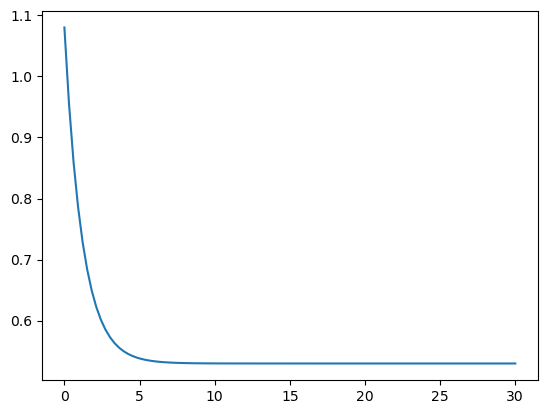

In [27]:
a = .55
b = .21 * 4
c = .53
def decay_rate_func(x):
    return a * np.exp(-b * x) + c

x = np.linspace(0, 30, 100)
y = decay_rate_func(x)

plt.plot(x, y)

In [28]:
def inverse_compute_discount_rate(df, decay_rate_func):
    """Inverse compute the discount rate for each deal in the dataframe, and plot the discount rate against the age of the deal
    
    Args:
        df (pd.DataFrame): the dataframe containing the deals data
        decay_rate_func (function): the decay rate function
    Returns:
        None
    Output:
        plot of discount rate against age.
    
    Notice that df is modified in place (a discount_rate column is added).
    """
    for idx, entry in df.iterrows():
        cashflow_table = pd.DataFrame(columns=['date', 'cash_flow'])
        age = entry['age']
        for i in range(1, int(entry['years_remaining']) + 1):  
            decay_rate = decay_rate_func(age + i) / decay_rate_func(age)
            cashflow_table.loc[i] = [i, entry['LTM'] * (decay_rate)]

        def f(r):
            dcf = DiscountedCashFlow(
                pricing_date=0,
                discount_rate=r,
                compound_frequency='a'
            )
            return dcf.price(cashflow_table) - entry['price']

        warnings.filterwarnings('error')
        try:
            r = fsolve(f, .1)[0]
        except RuntimeWarning:
            r = np.nan
        df.loc[idx, 'discount_rate'] = r
    
    df.dropna(subset=['discount_rate'], inplace=True)
    # plot the discount rate against the age
    plt.scatter(df['age'], df['discount_rate'])
    plt.xlabel('Age')
    plt.ylabel('Discount Rate')
    plt.title('Discount Rate vs Age for Life of Rights')
    plt.show()

### Life of Rights

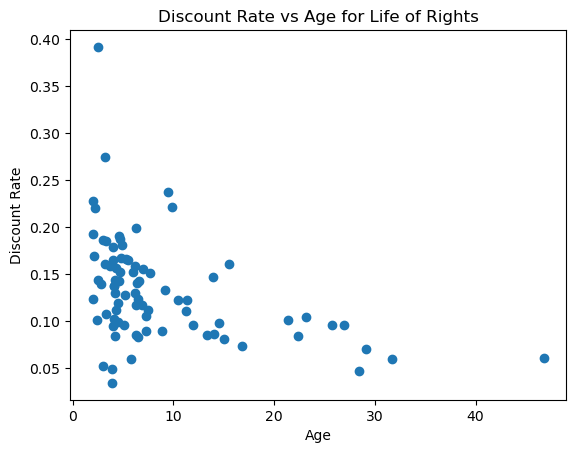

In [29]:
inverse_compute_discount_rate(df_life, decay_rate_func)

### 30-Year Rights

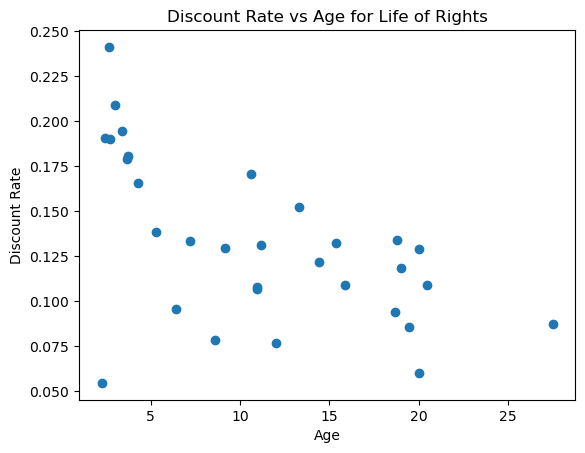

In [30]:
inverse_compute_discount_rate(df_30year, decay_rate_func)

### 10-Year Rights

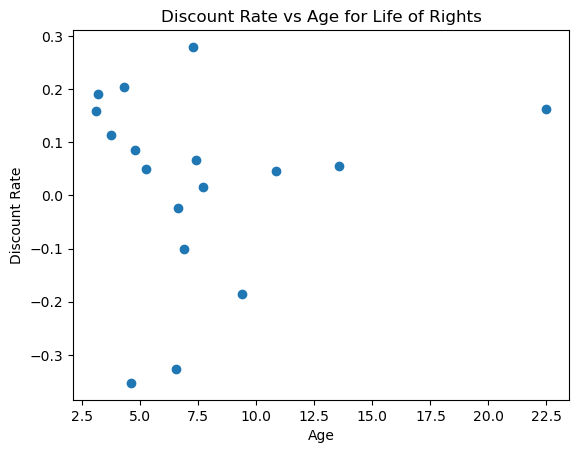

In [31]:
inverse_compute_discount_rate(df_10year, decay_rate_func)

In [60]:
df_10year['LTMtimesYearsRemaining'] = df_10year['LTM'] * df_10year['years_remaining']
df_10year['Ratio'] = df_10year['LTMtimesYearsRemaining'] / df_10year['price']
df_10year[['Ratio', 'name']]

,Ratio,name
14,1.301894,25-Year-Old #1 Dance Club Hit
62,1.004650,Multi-Platinum Ariana Grande & Justin Bieber
73,0.811292,Multi-Platinum Ariana Grande & Justin Bieber
213,1.665810,"Kevin Gates' Changing Lanes"" + more"""
315,2.899457,"Travis Scott's Hit Single FRANCHISE"" - Songwri..."
374,1.898044,Holiday Hits and More Pop Performance Royalties
385,2.232105,"Drug Addicts"" by Lil Pump + More - Songwriter ..."
404,2.618046,"Having Our Way"" From Migos + Drake"""
598,1.348971,Multi-Platinum “Cheerleader” by Omi - Songwrit...
628,2.685383,Lecrae & 1K Phew - Songwriter Royalties


## Exponential Decay: Minimizing Discount Rate Variance

In [61]:
df_life = df_deals[df_deals['type'] == 'Life of Rights'].copy()
df_30year = df_deals[df_deals['type'] == '30-Year'].copy()
df_10year = df_deals[df_deals['type'] == '10-Year'].copy()

In [62]:
def objective_function(x, df):
    a = x[0]
    b = x[1]
    c = x[2]
    for idx, entry in df.iterrows():
        cashflow_table = pd.DataFrame(columns=['date', 'cash_flow'])
        age = entry['age']

        for i in range(1, int(entry['years_remaining']) + 1):  # di = LTM * decay_rate^i for the first 10 years
            decay_rate = (a * (np.exp(-b * (age + i))) + c) / (a * (np.exp(-b * age)) + c)
            cashflow_table.loc[i] = [i, entry['LTM'] * (decay_rate)]

        def f(r):
            dcf = DiscountedCashFlow(
                pricing_date=0,
                discount_rate=r,
            )
            return dcf.price(cashflow_table) - entry['price']

        warnings.filterwarnings('error')
        try:
            r = fsolve(f, .1)[0]
        except RuntimeWarning:
            r = np.nan
        df.loc[idx, 'discount_rate'] = r
    return df['discount_rate'].var()

### Life or Rights

$$ d_i = ae^{-bi} + c$$

In [63]:
# find optimized parameters a*(e^(-b*x)) + c to minimize the variance of the revenue data
from scipy.optimize import minimize
# def optimize_decay_rate_param():
bnds = ((0, None), (0, None), (0, None))

res = minimize(objective_function, [1, 1, 1], df_life, method='Powell', tol=1e-3, bounds = bnds, options={'disp': True})
print(res.x)

Optimization terminated successfully.
         Current function value: 0.001028
         Iterations: 2
         Function evaluations: 102
[20.58476087  0.44621703  1.6490331 ]


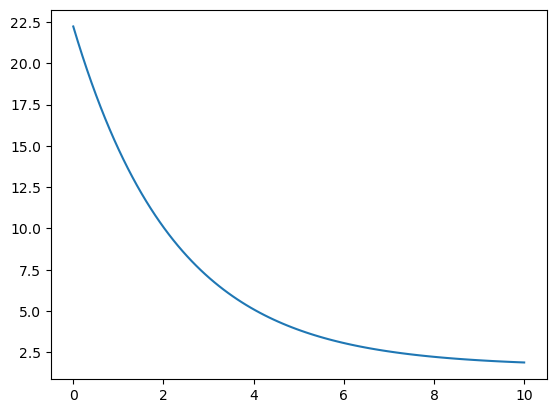

In [64]:
a, b, c = res.x
def decay_rate_func(x):
    return a * (np.exp(-b * x)) + c

# print the decay rate function
x = np.linspace(0, 10, 100)
y = decay_rate_func(x)

plt.plot(x, y)


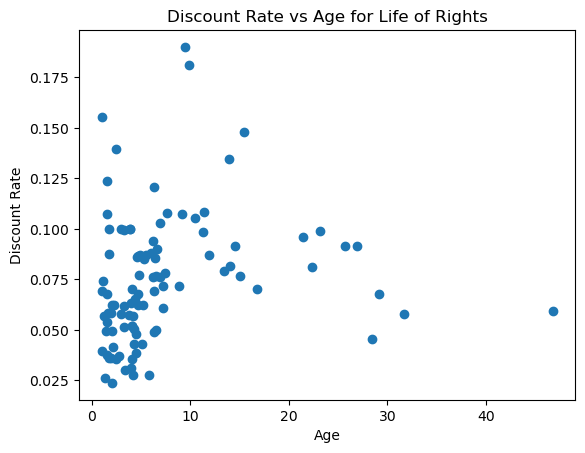

In [65]:
inverse_compute_discount_rate(df_life, decay_rate_func)

### 30-Year Rights

$$ d_i = ae^{-bi} + c$$

In [66]:
# find optimized parameters a*(e^(-b*x)) + c to minimize the variance of the revenue data
from scipy.optimize import minimize
# def optimize_decay_rate_param():
bnds = ((0, None), (0, None), (0, None))

res = minimize(objective_function, [1, 1, 1], df_30year, method='Powell', tol=1e-3, bounds = bnds, options={'disp': True})
print(res.x)

Optimization terminated successfully.
         Current function value: 0.001585
         Iterations: 3
         Function evaluations: 134
[11.08162136  0.84912741  1.12115484]


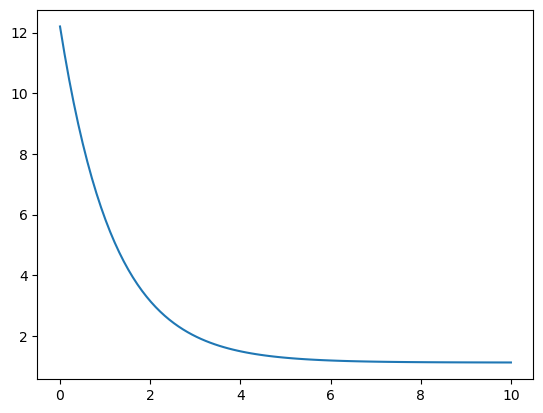

In [67]:
a, b, c = res.x
def decay_rate_func(x):
    return a * (np.exp(-b * x)) + c

# print the decay rate function
x = np.linspace(0, 10, 100)
y = decay_rate_func(x)

plt.plot(x, y)

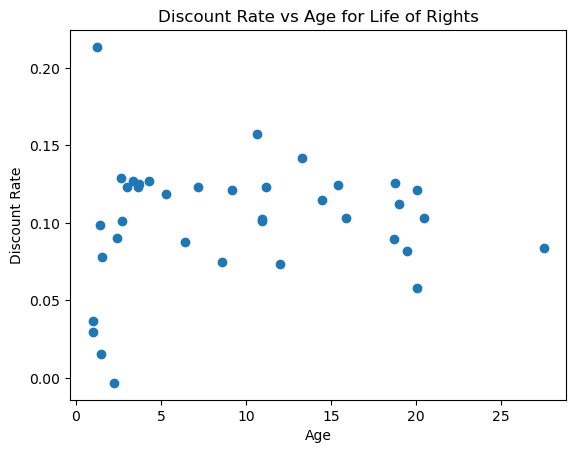

In [68]:
inverse_compute_discount_rate(df_30year, decay_rate_func)

### 10-Year Rights

$$ d_i = ae^{-bi} + c$$

In [69]:
# find optimized parameters a*(e^(-b*x)) + c to minimize the variance of the revenue data
from scipy.optimize import minimize
# def optimize_decay_rate_param():
bnds = ((0, None), (0, None), (0, None))

res = minimize(objective_function, [1, 1, 1], df_10year, method='Powell', tol=1e-3, bounds = bnds, options={'disp': True})
print(res.x)

Optimization terminated successfully.
         Current function value: 0.030229
         Iterations: 3
         Function evaluations: 131
[39.94347494  1.09396568  2.63507865]


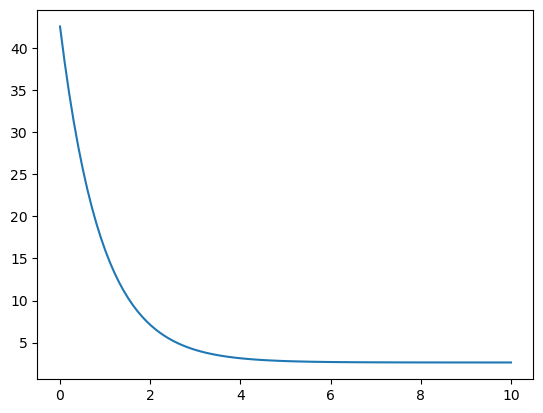

In [70]:
a, b, c = res.x
def decay_rate_function(x):
    return a * (np.exp(-b * x)) + c

# print the decay rate function
x = np.linspace(0, 10, 100)
y = decay_rate_function(x)

plt.plot(x, y)

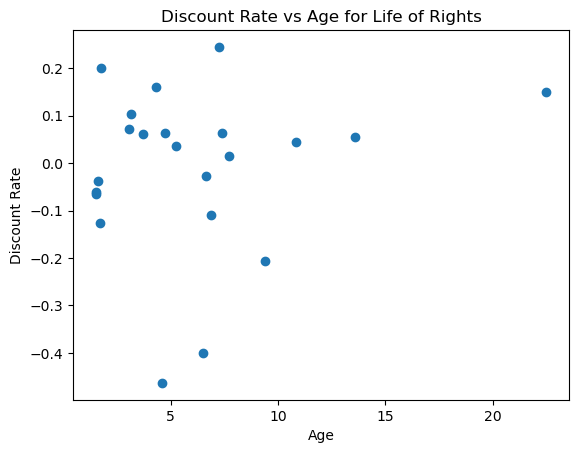

In [71]:
inverse_compute_discount_rate(df_10year, decay_rate_function)

## Linear Decay

In [74]:
def decary_rate_func(age):
    return min(0.86 + 0.01 * age, 0.96)


for idx, entry in df_deals.iterrows():
    decay_rate = decary_rate_func(entry['age'])
    cashflow_table = pd.DataFrame(columns=['date', 'cash_flow'])

    for i in range(1, min(int(entry['years_remaining']) + 1, 11)):  # di = LTM * decay_rate^i for the first 10 years
        cashflow_table.loc[i] = [i, entry['LTM'] * (decay_rate ** i)]
    if entry['type'] != '10-Year':  
        for i in range(11, 31):  # di = LTM * decay_rate^10 for the rest of the years
            cashflow_table.loc[i] = [i, entry['LTM'] * (decay_rate ** 10)]

    def f(r):
        dcf = DiscountedCashFlow(
            pricing_date=0,
            discount_rate=r,
        )
        return dcf.price(cashflow_table) - entry['price']

    warnings.filterwarnings('error')
    try:
        r = fsolve(f, .1)[0]
    except RuntimeWarning:
        r = np.nan
    df_deals.loc[idx, 'discount_rate'] = r

In [75]:
# Drop the rows where discount rate is NaN
df_deals.dropna(subset=['discount_rate'], inplace=True)

Text(0.5, 1.0, 'Discount Rate vs Age')

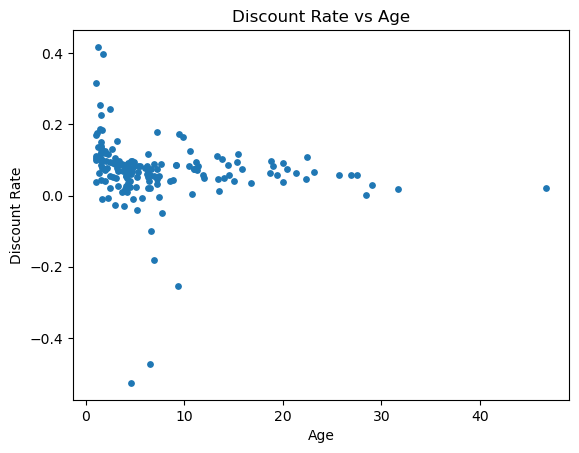

In [76]:
# Plot the discount rate vs age
plt.scatter(df_deals['age'], df_deals['discount_rate'], s=15)
plt.xlabel('Age')
plt.ylabel('Discount Rate')
plt.title('Discount Rate vs Age')

Text(0.5, 1.0, 'Discount Rate vs LTM')

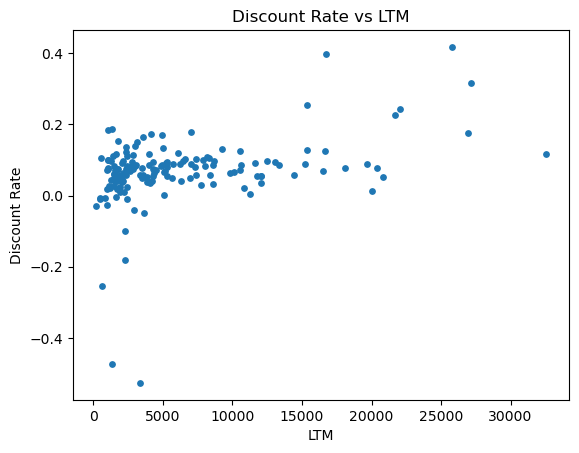

In [77]:
# Plot the discount rate vs LTM
plt.scatter(df_deals['LTM'], df_deals['discount_rate'], s=15)
plt.xlabel('LTM')
plt.ylabel('Discount Rate')
plt.title('Discount Rate vs LTM')